# Simple Machine Learining Models

Input: single principal component based on all 15 indicators 

Output: optimal max-shape portfolio with tight restrictions for the next period

In [10]:
import numpy as np

import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [2]:
data_provider = DataProvider()
x = data_provider.get_formatted_features(flatten=True)
y = data_provider.get_formatted_targets()
x_train, y_train, _, _, x_test, y_test = data_provider.train_train_split(x, y, with_val=False)

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
regressor_random_forest = RandomForestRegressor(n_estimators=32,
                                                random_state=42)
regressor_random_forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=32, random_state=42)

Checking example predictions

In [13]:
predictions = regressor_random_forest.predict(x_test)

In [14]:
predictions[0].round(3)

array([0.513, 0.066, 0.059, 0.032, 0.029, 0.024, 0.027, 0.024, 0.009,
       0.01 , 0.015, 0.011, 0.012, 0.014, 0.013, 0.007, 0.009, 0.008,
       0.033, 0.014, 0.014, 0.016, 0.011, 0.009, 0.01 , 0.005, 0.007])

In [15]:
y_test[0]

array([0.576, 0.046, 0.075, 0.023, 0.02 , 0.039, 0.017, 0.016, 0.007,
       0.008, 0.02 , 0.005, 0.02 , 0.02 , 0.004, 0.002, 0.002, 0.002,
       0.024, 0.025, 0.02 , 0.012, 0.006, 0.003, 0.004, 0.002, 0.002])

Checking portfolios to match 1.0

In [16]:
preditions_sum = predictions.sum(axis=1)
preditions_sum

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [17]:
preditions_sum = preditions_sum.reshape(predictions.shape[0], 1)
predictions = np.divide(predictions, preditions_sum)

In [18]:
predictions.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

## Gradient Boosting

In [19]:
import xgboost as xgb

In [20]:
regressor_xg_boosting = xgb.XGBRegressor(n_estimators=32,
                                         random_state=42)
regressor_xg_boosting.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=32, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [21]:
xg_boost_predictions = regressor_xg_boosting.predict(x_test)
xg_boost_predictions.sum(axis=1)

array([0.95003045, 1.0063559 , 1.0020456 , 1.0437537 , 0.94142795,
       0.9332473 , 0.9771983 , 0.9926595 , 1.0716672 , 1.0320423 ,
       1.0341406 , 1.0994397 , 1.0899624 , 0.9780509 , 0.9862272 ,
       0.98372   , 1.1205782 , 1.1548172 , 1.1182473 , 1.1347604 ,
       1.1382921 , 1.1496816 , 1.1233755 , 1.1250135 , 1.1232377 ,
       1.1014608 , 1.1037953 , 1.101491  , 1.0203712 , 1.1603177 ,
       1.1839852 , 1.1366026 , 1.1765342 , 1.1395209 , 1.0208534 ,
       1.043673  , 1.0207177 , 1.0850682 , 1.1043391 , 1.1927415 ,
       1.1135231 , 1.1710804 , 1.1866796 , 1.1625763 , 1.1300591 ,
       1.0853748 , 1.0174505 , 1.0249553 , 1.0322356 , 0.9899999 ,
       1.0797423 , 1.0033929 , 1.0659401 , 1.0375313 , 1.0691608 ,
       1.1342399 , 1.0588102 , 1.0055393 ], dtype=float32)

In [22]:
xg_boost_preditions_sum = xg_boost_predictions.sum(axis=1).reshape(xg_boost_predictions.shape[0], 1)
xg_boost_predictions = np.divide(xg_boost_predictions, xg_boost_preditions_sum)

In [23]:
xg_boost_predictions.sum(axis=1).round(3)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.], dtype=float32)

## Backtesting

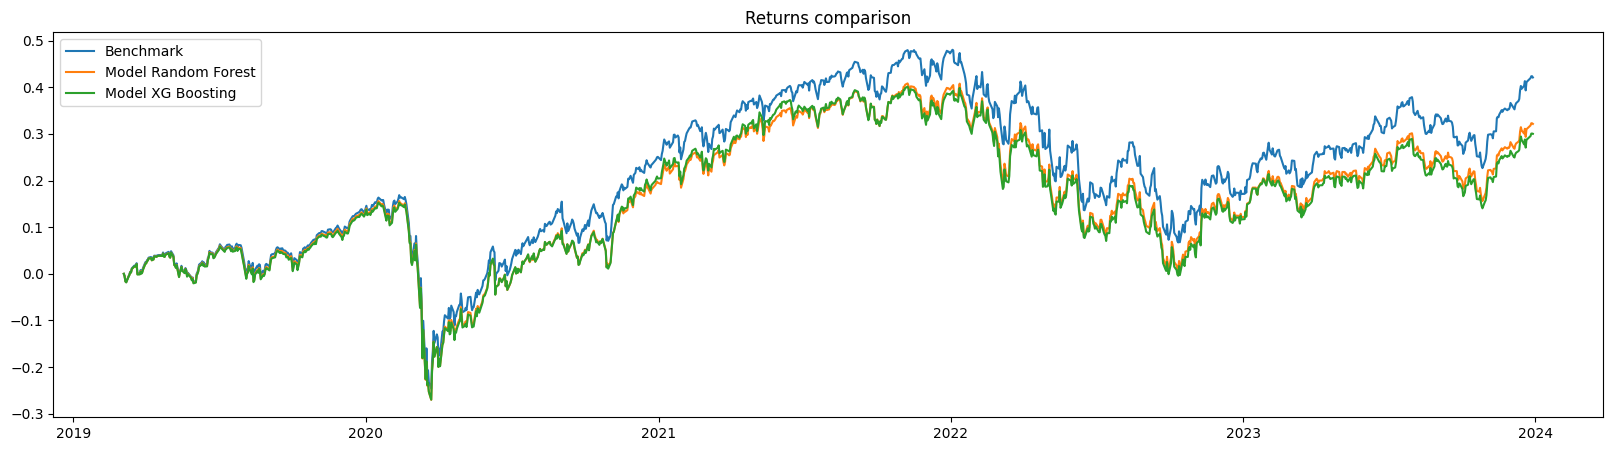

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Model Random Forest,0.059528,0.202518,0.293938,0.340403,-0.368443,538.0,0.161565,-0.655144
Model XG Boosting,0.05597,0.202604,0.276254,0.321425,-0.366288,538.0,0.152804,-0.632785


In [24]:
from helper_functions import run_full_backtesting

models = {
    'Model Random Forest': regressor_random_forest,
    'Model XG Boosting': regressor_xg_boosting
}

df_results = run_full_backtesting(data_provider, x_test, models)
df_results